In [1]:
%load_ext autoreload
%autoreload 2

In [457]:
from copy import deepcopy

import k3d
import yaml
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import json
import pymesh

import torch

import trimesh.transformations as tt
import trimesh
from io import BytesIO

from joblib import Parallel, delayed

In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '8'

In [4]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 1.0

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [5]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

## 1. Working with point patches

In [6]:
from sharpf.data import DataGenerationException
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.data.camera_pose_manager import POSE_MANAGER_BY_TYPE
from sharpf.data.datasets.sharpf_io import save_depth_maps
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.data.noisers import NOISE_BY_TYPE
from sharpf.utils.abc_utils.abc import feature_utils
from sharpf.utils.py_utils.console import eprint_t
from sharpf.utils.py_utils.os import add_suffix
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.camera_utils.camera_pose import camera_to_display
import sharpf.data.data_smells as smells
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased, compute_relative_indexes


In [137]:
with ABCChunk(['/data/abc/abc_0022_obj_v00.7z', '/data/abc/abc_0022_feat_v00.7z']) as data_holder:
    item = data_holder.get('00221312_0cdd179f2b755db6d27ea303_001')

In [138]:
item.item_id

'00221312_0cdd179f2b755db6d27ea303_001'

In [446]:
config = {
  "shape_fabrication_extent": 10.0,
  "short_curve_quantile": 0.25,
  "base_n_points_per_short_curve": 8,
  "base_resolution_3d": 0.125,
  "camera_pose": {
    "type": "composite",
    "sequences": [
      {
        "type": "sphere_to_origin",
        "n_images": 10
      }
    ]
  },
  "imaging": {
    "type": "raycasting",
    "projection": "ortho",
    "resolution_image": 512,
    "resolution_3d": 0.02,
    "fov": [115, 85, 80],
    "validate_image": True
  },
  "noise": {
    "type": "z_direction",
    "scale": 0.0
  },
  "annotation": {
    "type": "surface_based_aabb",
    "distance_upper_bound": 1.0
  },
  "smell_coarse_surfaces_by_num_edges": {
    "num_edges_threshold": 8
  },
  "smell_coarse_surfaces_by_angles": {
    "max_angle_threshold_degrees": 10.0
  },
  "smell_deviating_resolution": {
    "resolution_3d": 0.02,
    "resolution_deviation_tolerance": 0.01
  },
  "smell_sharpness_discontinuities": { },
  "smell_bad_face_sampling": {
    "min_points_per_face": 0.02,
    "max_points_per_face": 20.0
  },
  "smell_raycasting_background": { },
  "smell_mesh_self_intersections": { },
  "smell_depth_discontinuity": {
    "depth_discontinuity_threshold": 0.5
  }
}

In [447]:
shape_fabrication_extent = config.get('shape_fabrication_extent', 10.0)
base_n_points_per_short_curve = config.get('base_n_points_per_short_curve', 8)
base_resolution_3d = config.get('base_resolution_3d', LOW_RES)
short_curve_quantile = config.get('short_curve_quantile', 0.05)

pose_manager = load_func_from_config(POSE_MANAGER_BY_TYPE, config['camera_pose'])
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])
noiser = load_func_from_config(NOISE_BY_TYPE, config['noise'])
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, config['annotation'])

smell_coarse_surfaces_by_num_edges = smells.SmellCoarseSurfacesByNumEdges.from_config(config['smell_coarse_surfaces_by_num_edges'])
smell_coarse_surfaces_by_angles = smells.SmellCoarseSurfacesByAngles.from_config(config['smell_coarse_surfaces_by_angles'])
smell_deviating_resolution = smells.SmellDeviatingResolution.from_config(config['smell_deviating_resolution'])
smell_sharpness_discontinuities = smells.SmellSharpnessDiscontinuities.from_config(config['smell_sharpness_discontinuities'])
smell_bad_face_sampling = smells.SmellBadFaceSampling.from_config(config['smell_bad_face_sampling'])
smell_raycasting_background = smells.SmellRaycastingBackground.from_config(config['smell_raycasting_background'])
smell_depth_discontinuity = smells.SmellDepthDiscontinuity.from_config(config['smell_depth_discontinuity'])
smell_mesh_self_intersections = smells.SmellMeshSelfIntersections.from_config(config['smell_mesh_self_intersections'])

In [141]:
def scale_mesh(mesh, features, shape_fabrication_extent, resolution_3d,
               short_curve_quantile=0.05, n_points_per_short_curve=4):
    # compute standard size spatial extent
    mesh_extent = np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(shape_fabrication_extent / mesh_extent)

    # compute lengths of curves
    sharp_curves_lengths = feature_utils.get_curves_extents(mesh, features)

    least_len = np.quantile(sharp_curves_lengths, short_curve_quantile)
    least_len_mm = resolution_3d * n_points_per_short_curve

    scale = least_len_mm / least_len
    mesh = mesh.apply_scale(scale)

    return mesh, scale


In [142]:
mesh, _, _ = trimesh_load(item.obj)
features = yaml.load(item.feat, Loader=yaml.Loader)

In [143]:
mesh, mesh_scale = scale_mesh(mesh, features, shape_fabrication_extent, base_resolution_3d,
                              short_curve_quantile=short_curve_quantile,
                              n_points_per_short_curve=base_n_points_per_short_curve)

mesh = mesh.apply_translation(-mesh.vertices.mean(axis=0))

In [144]:
print(np.max(mesh.bounding_box.extents))

3.7860577612563175


In [145]:
processed_mesh = trimesh.base.Trimesh(vertices=mesh.vertices, faces=mesh.faces, process=True, validate=True)
if processed_mesh.vertices.shape != mesh.vertices.shape or \
        processed_mesh.faces.shape != mesh.faces.shape or not mesh.is_watertight:
    raise DataGenerationException('Will not process mesh {}: likely the mesh is broken'.format(item.item_id))

has_smell_mismatching_surface_annotation = any([
    np.array(np.unique(mesh.faces[surface['face_indices']]) != np.sort(surface['vert_indices'])).all()
    for surface in features['surfaces']
])
has_smell_mesh_self_intersections = smell_mesh_self_intersections.run(mesh)


In [146]:
sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in features['curves'] if c['sharp']]
)
sharp_vert = mesh.vertices[sharp_vert_indexes]


display_sharpness(
    mesh, plot_meshvert=False, meshvert_psize=HIGH_RES / 2,
    sharp_vert=sharp_vert, sharpvert_psize=MED_RES,
    samples=None, samples_psize=HIGH_RES,
)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [188]:
patches = []

# generate camera poses
pose_manager.prepare(mesh)

In [189]:
pose_manager_iter = iter(pose_manager)

In [371]:
camera_pose = next(pose_manager_iter)

StopIteration: 

In [354]:
# camera_to_world = np.linalg.inv(camera_pose.world_to_camera_4x4)

# # camera_to_world = pose.camera_to_world_4x4

# camera_center = np.array([
#     camera_pose.frame_origin,
#     camera_pose.frame_origin,
#     camera_pose.frame_origin,
# ])

# camera_frame = np.array([
#     camera_pose.frame_axes
# ]) * 25

# display_sharpness(
#     mesh, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
#     samples=camera_center, samples_psize=5.0,
#     directions=camera_frame
# )

In [355]:
# extract neighbourhood
try:
    image, points, normals, mesh_face_indexes = \
        imaging.get_image_from_pose(mesh, camera_pose, return_hit_face_indexes=True)
except DataGenerationException as e:
    eprint_t(str(e))

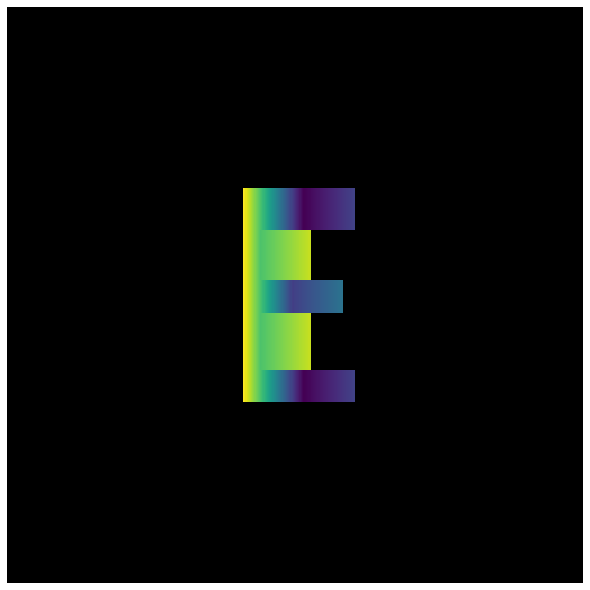

In [356]:
display_depth_sharpness(
    depth_images=[camera_to_display(image)]
)

In [357]:
has_smell_coarse_surfaces_by_num_edges = smell_coarse_surfaces_by_num_edges.run(mesh, mesh_face_indexes, features)
has_smell_coarse_surfaces_by_angles = smell_coarse_surfaces_by_angles.run(mesh, mesh_face_indexes, features)
has_smell_deviating_resolution = smell_deviating_resolution.run(points)
has_smell_bad_face_sampling = smell_bad_face_sampling.run(nbhood, points)
has_smell_raycasting_background = smell_raycasting_background.run(image)
has_smell_depth_discontinuity = smell_depth_discontinuity.run(image)

In [358]:
nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, mesh_face_indexes)

# create annotations: condition the features onto the nbhood
nbhood_features = feature_utils.compute_features_nbhood(
    mesh, features, mesh_face_indexes, mesh_vertex_indexes=mesh_vertex_indexes,
    deduce_verts_from_faces=False)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = feature_utils.remove_boundary_features(nbhood, nbhood_features, how='edges')

In [359]:
nbhood_sharp_vert_indexes = np.concatenate(
    [c['vert_indices'] for c in nbhood_features['curves'] if c['sharp']]
)
nbhood_sharp_vert = nbhood.vertices[nbhood_sharp_vert_indexes]


display_sharpness(
    nbhood, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    sharp_vert=nbhood_sharp_vert, sharpvert_psize=0.2,
    samples=camera_pose.camera_to_world(imaging.image_to_points(image)), samples_psize=0.1,
    directions=None
)

Output()

In [360]:
i = noiser.make_noise(
    camera_pose.world_to_camera(points),
    normals,
    z_direction=np.array([0., 0., -1.]))

In [361]:
configuration, noisy_points = next(i)

In [362]:
annotator.validate_annotation = False

In [363]:
# compute the TSharpDF
try:
    distances, directions, has_sharp = annotator.annotate(
        nbhood, nbhood_features, camera_pose.camera_to_world(noisy_points))
except DataGenerationException as e:
    eprint_t(str(e))

In [364]:
display_sharpness(
    nbhood, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=camera_pose.camera_to_world(noisy_points), samples_psize=HIGH_RES,
    samples_distances=distances,
)

Output()

In [365]:
ray_indexes = np.where(image.ravel() != 0)[0]
noisy_image = imaging.points_to_image(noisy_points, ray_indexes)
normals_image = imaging.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])
distances_image = imaging.points_to_image(distances.reshape(-1, 1), ray_indexes, assign_channels=[0])
directions_image = imaging.points_to_image(directions, ray_indexes, assign_channels=[0, 1, 2])

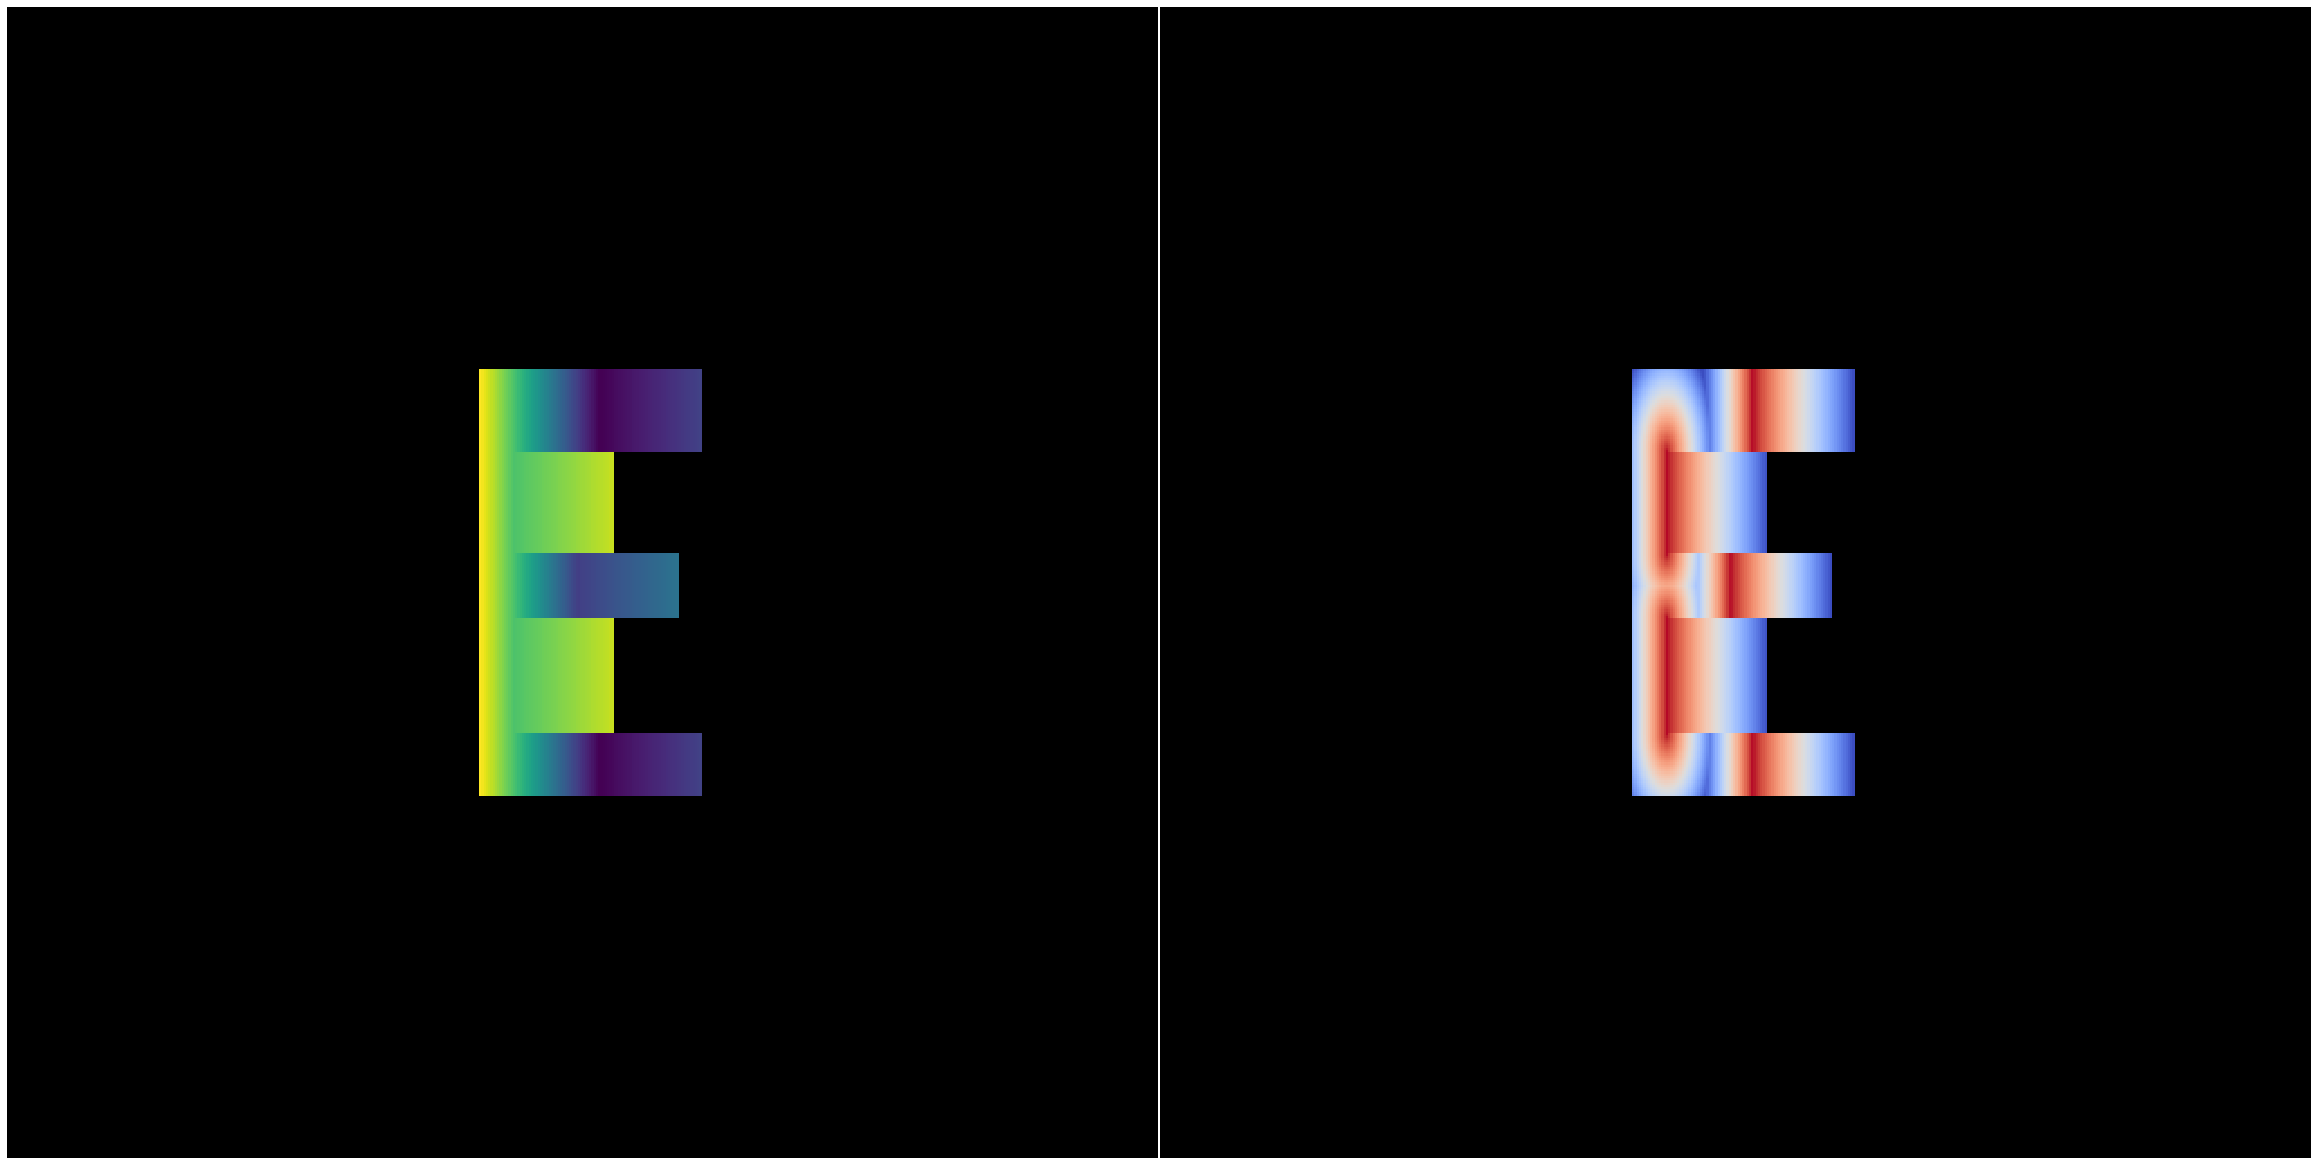

In [366]:
display_depth_sharpness(
    depth_images=[camera_to_display(noisy_image)],
    sharpness_images=[camera_to_display(distances_image)],
    axes_size=(16, 16), 
)

In [367]:
# compute statistics
num_sharp_curves = len([curve for curve in nbhood_features['curves'] if curve['sharp']])
num_surfaces = len(nbhood_features['surfaces'])

In [368]:
try:
    has_smell_sharpness_discontinuities = smell_sharpness_discontinuities.run(noisy_points, distances)
except Exception as e:
    eprint_t(str(e))
    

In [369]:
patch_info = {
    'image': noisy_image,
    'normals': normals_image,
    'distances': distances_image,
    'directions': directions_image,
    'item_id': item.item_id,
    'orig_vert_indices': mesh_vertex_indexes,
    'orig_face_indexes': mesh_face_indexes,
    'has_sharp': has_sharp,
    'num_sharp_curves': num_sharp_curves,
    'num_surfaces': num_surfaces,
    'camera_pose': camera_pose.camera_to_world_4x4,
    'mesh_scale': mesh_scale,
    'has_smell_coarse_surfaces_by_num_faces': has_smell_coarse_surfaces_by_num_edges,
    'has_smell_coarse_surfaces_by_angles': has_smell_coarse_surfaces_by_angles,
    'has_smell_deviating_resolution': has_smell_deviating_resolution,
    'has_smell_sharpness_discontinuities': has_smell_sharpness_discontinuities,
    'has_smell_bad_face_sampling': has_smell_bad_face_sampling,
    'has_smell_mismatching_surface_annotation': has_smell_mismatching_surface_annotation,
    'has_smell_raycasting_background': has_smell_raycasting_background,
    'has_smell_depth_discontinuity': has_smell_depth_discontinuity,
    'has_smell_mesh_self_intersections': has_smell_mesh_self_intersections,
}

In [370]:
patches.append(patch_info)

In [381]:
from sharpf.utils.camera_utils.camera_pose import CameraPose

In [427]:
whole_model_points = []
whole_model_distances = []

for patch in patches:
    image = patch['image']
    points_in_camera_frame = imaging.image_to_points(image)
    camera_to_world_4x4 = patch['camera_pose']
    camera_pose = CameraPose(camera_to_world_4x4)
    points_in_world_frame = camera_pose.camera_to_world(points_in_camera_frame)
    whole_model_points.append(points_in_world_frame)
    
    distances = patch['distances']
    whole_model_distances.append(distances.ravel()[np.where(distances.ravel() != 0.)[0]])
    

whole_model_points = np.concatenate(whole_model_points)
whole_model_distances = np.concatenate(whole_model_distances)

In [435]:
display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=whole_model_points,
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances,
)



Output()

In [420]:
import igl

In [429]:
nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, patches[0]['orig_face_indexes'])


In [433]:
distance_sq, face_indexes, _ = igl.point_mesh_squared_distance(
    whole_model_points,
    nbhood.vertices,
    nbhood.faces)
indexes = np.where(np.sqrt(distance_sq) < HIGH_RES / 100)[0]
points, normals = whole_model_points[indexes], nbhood.face_normals[face_indexes[indexes]]




In [450]:
from sharpf.utils.abc_utils.abc.feature_utils import compute_features_nbhood, remove_boundary_features, get_curves_extents

def compute_patches(
        patch,
        whole_model_points,
        mesh,
        features,
        noiser,
        annotator,
        smell_coarse_surfaces_by_num_edges,
        smell_coarse_surfaces_by_angles,
        smell_deviating_resolution,
        smell_bad_face_sampling,
        smell_sharpness_discontinuities):


    # extract neighbourhood
    nbhood, mesh_vertex_indexes, mesh_face_indexes = \
            feature_utils.submesh_from_hit_surfaces(mesh, features, patch['orig_face_indexes'])

    has_smell_coarse_surfaces_by_num_edges = smell_coarse_surfaces_by_num_edges.run(mesh, mesh_face_indexes, features)
    has_smell_coarse_surfaces_by_angles = smell_coarse_surfaces_by_angles.run(mesh, mesh_face_indexes, features)

    # create annotations: condition the features onto the nbhood
    nbhood_features = compute_features_nbhood(mesh, features, mesh_face_indexes,
                                              mesh_vertex_indexes=mesh_vertex_indexes)

    # remove vertices lying on the boundary (sharp edges found in 1 face only)
    nbhood_features = remove_boundary_features(nbhood, nbhood_features, how='edges')

    # sample the neighbourhood to form a point patch
#     try:
#         points, normals = sampler.sample(nbhood, centroid=nbhood_extractor.centroid)
#     except DataGenerationException as e:
#         eprint_t(str(e))
#         return None

    distance_sq, face_indexes, _ = igl.point_mesh_squared_distance(
        whole_model_points,
        nbhood.vertices,
        nbhood.faces)
    indexes = np.where(np.sqrt(distance_sq) < HIGH_RES / 100)[0]
    points, normals = whole_model_points[indexes], nbhood.face_normals[face_indexes[indexes]]

    has_smell_deviating_resolution = smell_deviating_resolution.run(points)
    has_smell_bad_face_sampling = smell_bad_face_sampling.run(nbhood, points)

    # create a noisy sample
    noisy_points = noiser.make_noise(points, normals, z_direction=np.array([0., 0., -1.]))
    
    try:
        distances, directions, has_sharp = annotator.annotate(nbhood, nbhood_features, noisy_points)
    except DataGenerationException as e:
        eprint_t(str(e))
        return None 

    has_smell_sharpness_discontinuities = smell_sharpness_discontinuities.run(noisy_points, distances)

    num_sharp_curves = len([curve for curve in nbhood_features['curves'] if curve['sharp']])
    num_surfaces = len(nbhood_features['surfaces'])
    patch = {
        'points': np.array(noisy_points).astype(np.float64),
        'normals': np.array(normals).astype(np.float64),
        'distances': np.array(distances).astype(np.float64),
        'directions': np.array(directions).astype(np.float64),
        'orig_vert_indices': np.array(mesh_vertex_indexes).astype(np.int32),
        'orig_face_indexes': np.array(mesh_face_indexes).astype(np.int32),
        'has_sharp': has_sharp,
        'num_sharp_curves': num_sharp_curves,
        'num_surfaces': num_surfaces,
        'has_smell_coarse_surfaces_by_num_faces': has_smell_coarse_surfaces_by_num_edges,
        'has_smell_coarse_surfaces_by_angles': has_smell_coarse_surfaces_by_angles,
        'has_smell_deviating_resolution': has_smell_deviating_resolution,
        'has_smell_sharpness_discontinuities': has_smell_sharpness_discontinuities,
        'has_smell_bad_face_sampling': has_smell_bad_face_sampling,
#         'has_smell_mismatching_surface_annotation': has_smell_mismatching_surface_annotation,
        'nbhood': nbhood,
        'indexes': indexes
    }
    return patch

In [454]:
patch = patches[0]
consolidated_patch = compute_patches(
    patch,
    whole_model_points,
    mesh,
    features,
    noiser,
    annotator,
    smell_coarse_surfaces_by_num_edges,
    smell_coarse_surfaces_by_angles,
    smell_deviating_resolution,
    smell_bad_face_sampling,
    smell_sharpness_discontinuities)

In [459]:
parallel = Parallel(n_jobs=16, backend='multiprocessing', verbose=100)
delayed_iterable = (delayed(compute_patches)(
    patch,
    whole_model_points,
    mesh,
    features,
    noiser,
    annotator,
    smell_coarse_surfaces_by_num_edges,
    smell_coarse_surfaces_by_angles,
    smell_deviating_resolution,
    smell_bad_face_sampling,
    smell_sharpness_discontinuities)
for patch in patches)
consolidated_patches = parallel(delayed_iterable)

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/joblib/parallel.py:741: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/joblib/parallel.py:741: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/joblib/parallel.py:741: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/joblib/parallel.py:741: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/joblib/parallel.py:741: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/user/miniconda/envs/py36/lib/

[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=16)]: Done   2 out of  10 | elapsed:  3.5min remaining: 14.0min
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:  3.6min remaining:  8.4min
[Parallel(n_jobs=16)]: Done   4 out of  10 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:  3.8min remaining:  3.8min
[Parallel(n_jobs=16)]: Done   6 out of  10 | elapsed:  3.8min remaining:  2.5min
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:  3.8min remaining:  1.6min
[Parallel(n_jobs=16)]: Done   8 out of  10 | elapsed:  4.1min remaining:  1.0min
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  6.8min finished


In [460]:
whole_model_distances = np.ones(len(whole_model_points)) * np.inf
whole_model_directions = np.ones( (len(whole_model_points), 3) ) * np.inf

for patch in tqdm(consolidated_patches):
    distances = patch['distances']
    directions = patch['directions']
    indexes = patch['indexes']

    assign_mask = whole_model_distances[indexes] > distances
    whole_model_distances[indexes[assign_mask]] = distances[assign_mask]
    whole_model_directions[indexes[assign_mask]] = directions[assign_mask]
    

100%|██████████| 10/10 [00:00<00:00, 500.99it/s]


In [461]:
display_sharpness(
    mesh, plot_meshvert=True, meshvert_psize=HIGH_RES / 2,
    samples=whole_model_points,
    samples_psize=HIGH_RES,
    samples_distances=whole_model_distances,
)




/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [117]:
row_indexes, col_indexes = np.arange(0, 512 - 64, 8), np.arange(0, 512 - 64, 8)

In [118]:
row_indexes

array([  0,   8,  16,  24,  32,  40,  48,  56,  64,  72,  80,  88,  96,
       104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200,
       208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304,
       312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408,
       416, 424, 432, 440])

In [125]:
def cut_into_overlapping_patches(
    noisy_image,
    normals,
    distances,
    directions,
    canvas_size,
    patch_size,
    overlap_amount,
):

    patch_images = []
    patch_normals = []
    patch_distances = []
    patch_directions = []
    patch_indexes = []

    row_indexes = np.arange(0, canvas_size - patch_size, overlap_amount)
    col_indexes = np.arange(0, canvas_size - patch_size, overlap_amount)
    
    for row in row_indexes:
        for col in col_indexes:
            patch_images.append(noisy_image[row:row + patch_size, col:col + patch_size])
            patch_normals.append(normals[row:row + patch_size, col:col + patch_size])
            patch_distances.append(distances[row:row + patch_size, col:col + patch_size])
            patch_directions.append(directions[row:row + patch_size, col:col + patch_size])
            patch_indexes.append([row, col])
    
    patch_images = np.array(patch_images)
    patch_normals = np.array(patch_normals)
    patch_distances = np.array(patch_distances)
    patch_directions = np.array(patch_directions)
    patch_indexes = np.array(patch_indexes)

    nonempty_indexes = np.where(~np.all(patch_images == 0., axis=(1,2)))[0]

    return (patch_images[nonempty_indexes],
            patch_normals[nonempty_indexes],
            patch_distances[nonempty_indexes],
            patch_directions[nonempty_indexes],
            patch_indexes[nonempty_indexes])

In [126]:
patch_images, patch_normals, patch_distances, patch_directions, patch_indexes = cut_into_overlapping_patches(
    noisy_image,
    normals,
    distances,
    directions,
    canvas_size=512,
    patch_size=64,
    overlap_amount=8)

In [129]:
display_depth_sharpness(
    depth_images=patch_images[120:240],
    sharpness_images=patch_distances[120:240],
    axes_size=(16, 16),
    ncols=15
)

In [127]:
patch_normals.shape

(566, 64, 64, 3)

In [91]:
patch_distances = []
patch_images = []

for row in row_indexes:
    for col in col_indexes:
        patch_distances.append(distances[row:row + 32, col:col + 32])
        patch_images.append(image[row:row + 32, col:col + 32])
        
display_images = np.array(display_images)
display_distances = np.array(display_distances)

In [93]:
display_images.shape

(3600, 32, 32)

In [97]:
nonempty_indexes = np.where(~np.all(display_images == 0., axis=(1,2)))[0]
nonempty_indexes.shape

(372,)